In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

In [2]:
print(torch.cuda.is_available())

False


In [3]:
device = 'cpu'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
trainset = torchvision.datasets.MNIST(
    'mnist',
    train=True,
    download=True,
    transform = transform
)

testset = torchvision.datasets.MNIST(
    'mnist',
    train=False,
    download=True,
    transform = transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 75062262.69it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82799517.31it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28401551.50it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11832626.56it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [6]:
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
import numpy as np
train_images = np.array([np.array(image[0])/255.0 for image in trainset])
train_labels = np.array([label for _,label in trainset])

**Numpy only implementation of CNN**

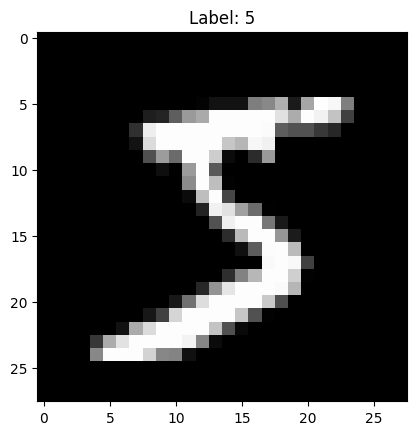

In [8]:
import matplotlib.pyplot as plt
image = train_images[0].reshape(28,28)
plt.imshow(image,cmap='gray')
plt.title(f'Label: {train_labels[0]}')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

In [10]:
train_images[0].shape

(1, 28, 28)

In [11]:
def convolution(image, filt, bias, s=1):

    (n_f, n_c_f, f, _) = filt.shape
    n_c, in_dim1, in_dim2 = image.shape

    out_dim1 = int((in_dim1 - f)/s) + 1
    out_dim2 = int((in_dim2 - f)/s) + 1

    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"

    out = np.zeros((n_f,out_dim1,out_dim2))

    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim1:
            curr_x = out_x = 0
            while curr_x + f <= in_dim2:
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1

            curr_y += s
            out_y += 1

    return out

In [12]:
def maxpool(image, f=2, s=2):

    n_c, h_prev, w_prev = image.shape

    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1

    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled

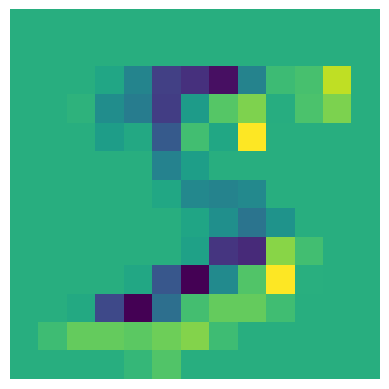

In [13]:
filt = np.random.randn(32,1,3,3)
bias = np.random.randn(32)
output = convolution(train_images[0],filt,bias,s=1)
output = maxpool(output,2,2)
output_reshaped2 = np.array(output[0]).transpose(0,1)
plt.imshow(output_reshaped2)
plt.axis('off')
plt.show()

In [14]:
def softmax(X):
    X_max = np.max(X)
    X_normalized = X - X_max
    out = np.exp(X_normalized + 1e-10)
    return out / np.sum(out)

def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

In [15]:
def flatten(x):
    return x.reshape(-1)

def fully_connected(x, W, b):
    return np.dot(x, W) + b

In [16]:
def relu(X):
    return np.maximum(0, X)

In [17]:
def cnn_forward(image, filters1, filters2, W1, b1, W2, b2):

    #First convolution layer with maxpool
    conv1 = convolution(image, filters1, np.random.randn(filters1.shape[0]),s=1)
    conv1 = relu(conv1)
    pooled1 = maxpool(conv1)

    #Second convolution layer with maxpool
    conv2 = convolution(pooled1, filters2, np.random.randn(filters2.shape[0]),s=1)
    conv2 = relu(conv2)
    pooled2  = maxpool(conv2)


    #Flattening after convolutions
    flattened = flatten(pooled2)

    #First fully connected layer
    fc1 = fully_connected(flattened, W1, b1)
    fc1 = relu(fc1)

    #Second fully connected layer
    fc2 = fully_connected(fc1, W2, b2)



    #Output
    output = softmax(fc2)


    cache = (fc1, fc2, flattened, pooled1, pooled2, conv1, conv2)

    return output,cache

In [18]:
def initialize_filters(size, scale=1.0):
    stddev = scale * np.sqrt(2.0 / sum(size))
    return np.random.normal(loc=0, scale=stddev, size=size)

def initialize_bias(size):
    return np.zeros(size)

In [19]:
filters1 = initialize_filters((32, 1, 5, 5))
filters2 = initialize_filters((64, 32, 5, 5))

W1 = initialize_filters((1024, 1024))
b1 = initialize_bias(1024)

W2 = initialize_filters((1024, 10))
b2 = initialize_bias(10)

In [20]:
def relu_derivative(x):
    return (x > 0) * 1

In [21]:
def convolutionBackward(dconv_prev, conv_in, filt, s):

    (n_f, n_c, f, _) = filt.shape
    conv_in = np.array(conv_in)
    (_, orig_dim, _) = conv_in.shape

    dout = np.zeros(conv_in.shape)
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))

    for curr_f in range(n_f):

        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:

                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]

                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1


        dbias[curr_f] = np.sum(dconv_prev[curr_f])

    return dout, dfilt, dbias

In [22]:
def maxpoolBackward(dpool, orig, f, s):

    (n_c, orig_dim, _) = orig.shape

    dout = np.zeros(orig.shape)

    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                pool_region = orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f]
                max_index = np.nanargmax(pool_region)

                a, b = np.unravel_index(max_index, pool_region.shape)
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]

                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1

    return dout

In [23]:
def cnn_backward(dL_dOutput, cache, parameters, learning_rate,current_image):

    fc1, fc2, flattened, pooled1, pooled2, conv1, conv2 = cache
    W1, b1, W2, b2, filters1, filters2 = parameters.values()

    if dL_dOutput.ndim == 1:
        dL_dOutput = dL_dOutput[np.newaxis, :]

    dL_dfc2 = dL_dOutput

    dL_dfc1 = np.dot(dL_dfc2, W2.T)

    if fc1.ndim == 1:
      fc1 = fc1[np.newaxis, :]

    dL_dW2 = np.dot(fc1.T, dL_dfc2)
    dL_db2 = np.sum(dL_dfc2, axis=0)
    dL_dfc1 *= relu_derivative(fc1)

    dL_dflattened = np.dot(dL_dfc1, W1.T)

    if flattened.ndim == 1:
      flattened = flattened[np.newaxis, :]

    dL_dW1 = np.dot(flattened.T, dL_dfc1)
    dL_db1 = np.sum(dL_dfc1, axis=0)


    dL_dpooled2 = dL_dflattened.reshape(pooled2.shape)

    dL_dconv2 = maxpoolBackward(dL_dpooled2, pooled2, f=2, s=2)



    dL_dpooled1, dL_dW_conv2, dL_db_conv2 = convolutionBackward(dL_dconv2, pooled1, filters2, s=2)

    dL_dconv1 = maxpoolBackward(dL_dpooled1, conv1, f=2, s=2)


    _, dL_dW_conv1, dL_db_conv1 = convolutionBackward(dL_dconv1, current_image, filters1, s=2)

    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    filters1 -= learning_rate * dL_dW_conv1
    filters2 -= learning_rate * dL_dW_conv2

    updated_parameters = {
        "W1": W1, "b1": b1, "W2": W2, "b2": b2, "filters1": filters1, "filters2": filters2
    }

    return updated_parameters

In [24]:
num_classes = 10
one_hot_labels = np.zeros((train_labels.size,num_classes))
one_hot_labels[np.arange(train_labels.size),train_labels] = 1

In [25]:
train_labels

array([5, 0, 4, ..., 5, 6, 8])

In [26]:
learning_rate = 0.001
epochs = 1
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "filters1": filters1, "filters2": filters2}

In [27]:
train_size = train_labels.size

In [28]:

filters1 = parameters['filters1']
filters2 = parameters['filters2']
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']

output,cache = cnn_forward(train_images[0], filters1, filters2, W1, b1, W2, b2)

In [29]:
print(output)

[1.28311395e-01 2.62783905e-02 2.70833429e-01 4.96266900e-02
 1.25239277e-01 3.51842180e-01 7.67253346e-03 3.19066209e-04
 3.82807058e-02 1.59633232e-03]


In [44]:
for epoch in range(epochs):
    print("Epoch number ",epoch)
    for i in range(101):

        current_image = train_images[i]
        current_label = one_hot_labels[i]
        filters1 = parameters['filters1']
        filters2 = parameters['filters2']
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']


        output,cache = cnn_forward(current_image, filters1, filters2, W1, b1, W2, b2)

        loss = np.sum((output - current_label) ** 2)
        dL_dOutput = output - current_label

        parameters = cnn_backward(dL_dOutput, cache, parameters, learning_rate,current_image)
        if (i%50==0):
            print(f'{i} Image completed!')


Epoch number  0
0 Image completed!
50 Image completed!
100 Image completed!


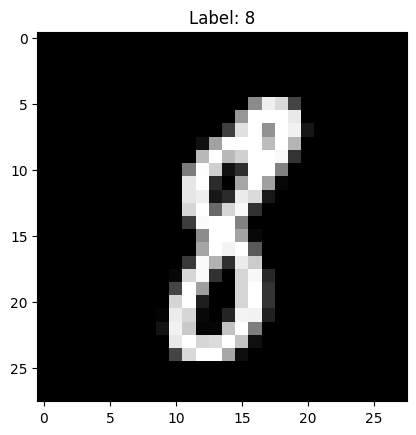

In [31]:
test_label = train_labels[300]
test_image = train_images[300].reshape(28,28)
plt.imshow(test_image,cmap='gray')
plt.title(f'Label: {test_label}')
plt.show()

**Testing**

In [32]:
filters1 = parameters['filters1']
filters2 = parameters['filters2']
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']

In [33]:
accuracy = 0
correct_predictions = 0
testset = torchvision.datasets.MNIST(
    'mnist',
    train=False,
    download=True,
    transform = transform
)
test_images = np.array([np.array(image[0])/255.0 for image in testset])
test_labels = np.array([label for _,label in testset])

In [34]:
test_size = test_labels.size
test_size

10000

In [45]:
accuracy = 0
correct_predictions = 0

In [46]:
for i in range(100):
    out,cache = cnn_forward(test_images[i], filters1, filters2, W1, b1, W2, b2)
    label = np.argmax(out)
    if label == test_labels[i]:
        correct_predictions += 1
accuracy = correct_predictions
print("Number of correct predictions: ",correct_predictions)
print("Accuracy: ",accuracy/100)

Number of correct predictions:  17
Accuracy:  0.17
